# 1° Proyecto individual - Juan Sebastian Cifuentes
## Modelo de recomentación de películas

In [6]:
# Importación de librerías
import pandas as pd
import numpy as np
import json
import ast
import re
from pandas import json_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## ETL

In [16]:
# Carga del dataset
df_anidado = pd.read_csv("movies_dataset.csv")

# Desanidar la columna 'belongs_to_collection'

# Reemplazar comillas simples por comillas dobles en la columna 'belongs_to_collection'
df_anidado['belongs_to_collection'] = df_anidado['belongs_to_collection'].str.replace("'", '"')

# Convertir los valores a strings
df_anidado['belongs_to_collection'] = df_anidado['belongs_to_collection'].astype(str)

# Limpiar los valores nulos (NaN) en la columna 'belongs_to_collection'
df_anidado = df_anidado.dropna(subset=['belongs_to_collection'])

# Función para intentar cargar un valor como JSON
def try_parse_json(value):
    try:
        return json.loads(value)
    except json.JSONDecodeError:
        return None

# Convertir la columna 'belongs_to_collection' a diccionarios JSON y contar los éxitos y errores
num_success = 0
num_errors = 0
for value in df_anidado['belongs_to_collection']:
    parsed_value = try_parse_json(value)
    if parsed_value is not None:
        num_success += 1
    else:
        num_errors += 1

# Imprimir los resultados
print(f"Registros desanidados con éxito: {num_success}")
print(f"Registros con error de formato: {num_errors}")



/tmp/ipykernel_17562/1259901949.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anidado = pd.read_csv("movies_dataset.csv")


Registros desanidados con éxito: 3171
Registros con error de formato: 42295


In [18]:
# Limpiar los valores nulos (NaN) en la columna 'belongs_to_collection'
df_anidado = df_anidado.dropna(subset=['belongs_to_collection'])

# Función para desanidar valores con la clave 'name'
def extract_name(value):
    try:
        parsed_value = json.loads(value)
        if isinstance(parsed_value, dict) and 'name' in parsed_value:
            return parsed_value['name']
        else:
            return None
    except json.JSONDecodeError:
        return None

# Aplicar la función y crear una nueva columna 'collection_name'
df_anidado['collection_name'] = df_anidado['belongs_to_collection'].apply(extract_name)

# Imprimir estadísticas
total_records = len(df_anidado)
valid_records = df_anidado['collection_name'].count()
invalid_records = total_records - valid_records

print(f"Total de registros: {total_records}")
print(f"Registros desanidados con éxito: {valid_records}")
print(f"Registros con error de formato: {invalid_records}")

collection_name_counts = df_anidado['collection_name'].value_counts()
print("\nFrecuencia de nombres de colecciones:")
print(collection_name_counts)

Total de registros: 45466
Registros desanidados con éxito: 3168
Registros con error de formato: 42298

Frecuencia de nombres de colecciones:
collection_name
The Bowery Boys                     29
Totò Collection                     27
James Bond Collection               26
Zatôichi: The Blind Swordsman       26
The Carry On Collection             25
                                    ..
Richard the Lionheart Collection     1
Old Way Collection                   1
Isi/Disi Collection                  1
Wodehouse P.G. Collection            1
Red Lotus Collection                 1
Name: count, Length: 1078, dtype: int64


In [19]:
# Eliminar las columnas que no serán utilizadas: video,imdb_id,adult,original_title,poster_path y homepage.
df_desanidado = df_anidado.drop(columns=['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage'], errors='ignore')

# Rellenar los valores nulos de las columnas 'revenue' y 'budget' con 0
df_desanidado['revenue'].fillna(0, inplace=True)
df_desanidado['budget'].fillna(0, inplace=True)

# Eliminar las filas con valores nulos en el campo 'release date'
df_desanidado.dropna(subset=['release_date'], inplace=True)

# Convertir el campo 'release_date' al formato AAAA-mm-dd
df_desanidado['release_date'] = pd.to_datetime(df_desanidado['release_date'], format='%Y-%m-%d', errors='coerce')

# Eliminar las filas con valores NaT en la columna 'release_date'
df_desanidado.dropna(subset=['release_date'], inplace=True)

# Extraer el año del campo 'release_date' y asignarlo a la nueva columna 'release_year'
df_desanidado['release_year'] = df_desanidado['release_date'].dt.year

# Función para calcular el retorno de inversión
def calcular_retorno_inversion(revenue, budget):
    if pd.notna(revenue) and pd.notna(budget):
        try:
            revenue = float(revenue)
            budget = float(budget)
            if budget != 0:
                return revenue / budget
            else:
                return 0
        except ValueError:
            return 0
    else:
        return 0

# Crear la columna 'return' aplicando la función a las columnas 'revenue' y 'budget'
df_desanidado['return'] = df_desanidado.apply(lambda row: calcular_retorno_inversion(row['revenue'], row['budget']), axis=1)


# Mostrar el DataFrame desanidado
#df_desanidado.head()
df_desanidado.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,collection_name,release_year,return
0,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,7.7,5415.0,Toy Story Collection,1995,12.451801
1,nan,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,None,1995,4.043035
2,"{""id"": 119050, ""name"": ""Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,Grumpy Old Men Collection,1995,0.000000
3,nan,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,None,1995,5.090760
4,"{""id"": 96871, ""name"": ""Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,Father of the Bride Collection,1995,0.000000


In [32]:
# Cargar dataset credits
df_credits = pd.read_csv("credits.csv", low_memory=False)
# Cambiar el id a int
df_desanidado['id'] = df_desanidado['id'].astype(int)
# Combinar los DataFrames por la columna 'id'
df_combinado = df_desanidado.merge(df_credits, on='id', how='left')  # Cambia 'how' según tu necesidad (inner, outer, left, right)
# Eliminar los valores duplicados en la columna 'title'
df_combinado.drop_duplicates(subset=['title'], inplace=True)
# Mostrar el DataFrame combinado
df_combinado.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,status,tagline,title,vote_average,vote_count,collection_name,release_year,return,cast,crew
0,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,Released,NaN,Toy Story,7.7,5415.0,Toy Story Collection,1995,12.451801,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,nan,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,None,1995,4.043035,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"{""id"": 119050, ""name"": ""Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,Grumpy Old Men Collection,1995,0.000000,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,nan,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,None,1995,5.090760,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,"{""id"": 96871, ""name"": ""Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,Father of the Bride Collection,1995,0.000000,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


## EDA

In [33]:
# Obtener información general sobre el DataFrame, incluyendo el número de filas y columnas, tipos de datos, etc.
print(df_combinado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 42196 entries, 0 to 45451
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   belongs_to_collection  42196 non-null  object        
 1   budget                 42196 non-null  object        
 2   genres                 42196 non-null  object        
 3   id                     42196 non-null  int64         
 4   original_language      42185 non-null  object        
 5   overview               41294 non-null  object        
 6   popularity             42196 non-null  object        
 7   production_companies   42196 non-null  object        
 8   production_countries   42196 non-null  object        
 9   release_date           42196 non-null  datetime64[ns]
 10  revenue                42196 non-null  float64       
 11  runtime                41957 non-null  float64       
 12  spoken_languages       42196 non-null  object        
 13  status

In [35]:
# Dejar solo los valores únicos del campo 'title'
df_combinado.drop_duplicates(subset=['title'], keep='first', inplace=True)

# Eliminar filas con valores nulos en las columnas 'homepage', 'imdb_id', 'popularity', 'overview'
df_combinado.dropna(subset=['original_language','runtime','crew'], inplace=True)

# Rellenar valores nulos en 'belongs_to_collection' 'overview' 'poster_path' 'tagline' y 'status' con una cadena vacía
columnas_a_rellenar = ['original_language','overview','status','tagline']
df_combinado[columnas_a_rellenar] = df_combinado[columnas_a_rellenar].fillna('')

# Contar el número de valores nulos en cada columna
print(df_combinado.isnull().sum())

belongs_to_collection        0
budget                       0
genres                       0
id                           0
original_language            0
overview                     0
popularity                   0
production_companies         0
production_countries         0
release_date                 0
revenue                      0
runtime                      0
spoken_languages             0
status                       0
tagline                      0
title                        0
vote_average                 0
vote_count                   0
collection_name          38872
release_year                 0
return                       0
cast                         0
crew                         0
dtype: int64


In [36]:
print(df_combinado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 41945 entries, 0 to 45451
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   belongs_to_collection  41945 non-null  object        
 1   budget                 41945 non-null  object        
 2   genres                 41945 non-null  object        
 3   id                     41945 non-null  int64         
 4   original_language      41945 non-null  object        
 5   overview               41945 non-null  object        
 6   popularity             41945 non-null  object        
 7   production_companies   41945 non-null  object        
 8   production_countries   41945 non-null  object        
 9   release_date           41945 non-null  datetime64[ns]
 10  revenue                41945 non-null  float64       
 11  runtime                41945 non-null  float64       
 12  spoken_languages       41945 non-null  object        
 13  status

In [37]:
# Convertir las columnas 'budget' y 'popularity' a tipo numérico (float64)
df_combinado['budget'] = pd.to_numeric(df_combinado['budget'], errors='coerce')
df_combinado['popularity'] = pd.to_numeric(df_combinado['popularity'], errors='coerce')

# Rellenar valores nulos en 'runtime' con el promedio de los valores no nulos
df_combinado['runtime'].fillna(df_combinado['runtime'].mean(), inplace=True)

# Cambiar el tipo de dato del campo 'budget' a float64
df_combinado['budget'] = df_combinado['budget'].astype(float)

# Verificar los tipos de datos después de la conversión
print(df_combinado.dtypes)

belongs_to_collection            object
budget                          float64
genres                           object
id                                int64
original_language                object
overview                         object
popularity                      float64
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
vote_average                    float64
vote_count                      float64
collection_name                  object
release_year                      int32
return                          float64
cast                             object
crew                             object
dtype: object


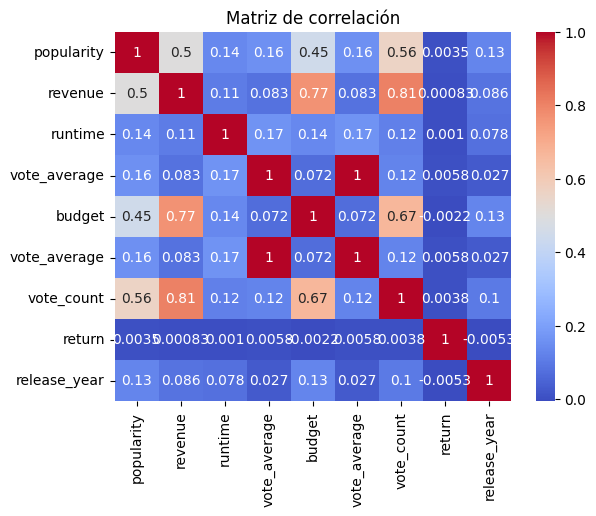

In [38]:
# Seleccionar solo las columnas de interés
columnas_seleccionadas = ['popularity', 'revenue', 'runtime', 'vote_average','budget','vote_average','vote_count','return','release_year']
df_seleccionado = df_combinado[columnas_seleccionadas]

# Calcular la matriz de correlación para las columnas seleccionadas
correlation_matrix = df_seleccionado.corr()

# Visualizar la matriz de correlación con un mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()


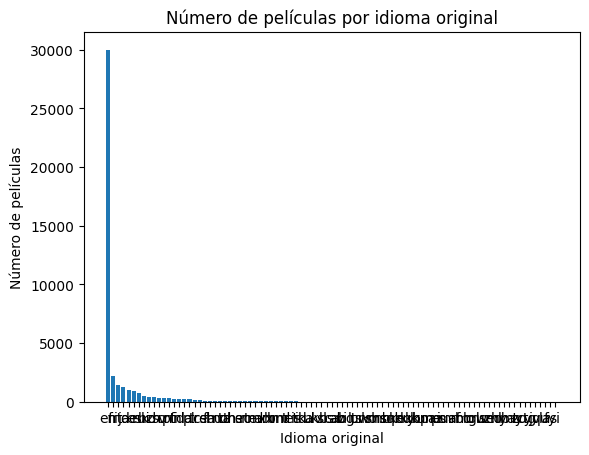

In [39]:
# Explorar la distribución de valores únicos en 'original_language'
plt.bar(df_combinado['original_language'].value_counts().index, df_combinado['original_language'].value_counts())
plt.xlabel('Idioma original')
plt.ylabel('Número de películas')
plt.title('Número de películas por idioma original')
plt.show()

In [40]:
# Mostrar las 10 principales categorías de 'genres'
top_genres = df_combinado['genres'].value_counts().nlargest(10)
print(top_genres)

genres
[{'id': 18, 'name': 'Drama'}]                                                                    4531
[{'id': 35, 'name': 'Comedy'}]                                                                   3404
[{'id': 99, 'name': 'Documentary'}]                                                              2604
[]                                                                                               2155
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                  1189
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]                                      1081
[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]                                  886
[{'id': 27, 'name': 'Horror'}]                                                                    877
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]     559
[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]                

In [41]:
# Función para convertir los valores de 'genres' en listas de diccionarios
def convert_to_list(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

# Aplicar la función para convertir los valores de 'genres'
df_combinado['genres'] = df_combinado['genres'].apply(convert_to_list)

# Función para obtener los nombres de género de una lista de diccionarios
def get_genre_names(genre_list):
    genre_names = [genre['name'] for genre in genre_list]
    return ', '.join(genre_names)

# Aplicar la función para obtener los nombres de género como una lista
df_combinado['genres_str'] = df_combinado['genres'].apply(get_genre_names)

# Mostrar el DataFrame con la nueva columna 'genres_str'
print(df_combinado[['genres', 'genres_str']].head())

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                   genres_str  
0   Animation, Comedy, Family  
1  Adventure, Fantasy, Family  
2             Romance, Comedy  
3      Comedy, Drama, Romance  
4                      Comedy  


In [42]:
# Mostrar las 10 principales categorías de 'genres'
top_genres = df_combinado['genres_str'].value_counts().nlargest(10)
print(top_genres)

genres_str
Drama                     4531
Comedy                    3404
Documentary               2604
                          2155
Drama, Romance            1189
Comedy, Drama             1081
Comedy, Romance            886
Horror                     877
Comedy, Drama, Romance     559
Drama, Comedy              499
Name: count, dtype: int64


In [43]:
# Ver tabla con ajustes
df_combinado.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,tagline,title,vote_average,vote_count,collection_name,release_year,return,cast,crew,genres_str
0,"{""id"": 10194, ""name"": ""Toy Story Collection"", ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,,Toy Story,7.7,5415.0,Toy Story Collection,1995,12.451801,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","Animation, Comedy, Family"
1,nan,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,None,1995,4.043035,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","Adventure, Fantasy, Family"
2,"{""id"": 119050, ""name"": ""Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,Grumpy Old Men Collection,1995,0.000000,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","Romance, Comedy"
3,nan,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,...,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,None,1995,5.090760,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","Comedy, Drama, Romance"
4,"{""id"": 96871, ""name"": ""Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,Father of the Bride Collection,1995,0.000000,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",Comedy


In [44]:
# Guardar el DataFrame limbio en formato CSV
df_combinado.to_csv('df_movies_clean.csv', index=False)
print(df_combinado.dtypes)

belongs_to_collection            object
budget                          float64
genres                           object
id                                int64
original_language                object
overview                         object
popularity                      float64
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
vote_average                    float64
vote_count                      float64
collection_name                  object
release_year                      int32
return                          float64
cast                             object
crew                             object
genres_str                       object
dtype: object


## Modelo de Machine Learning

In [29]:
# Crear una lista con los nombres de las columnas que deseas seleccionar
columnas_seleccionadas = ['title', 'genres_str', 'overview']

# Usar el método 'loc' para seleccionar solo las columnas deseadas
df_model = df_combinado.loc[:, columnas_seleccionadas]

# Filtrar el DataFrame para mantener solo los registros que contengan 'Comedy' en 'genres_str'
df_comedia = df_model[df_combinado['genres_str'].str.contains('Comedy')]

# Mostrar el nuevo DataFrame con las películas de comedia
print(df_comedia.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13195 entries, 0 to 45441
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       13195 non-null  object
 1   genres_str  13195 non-null  object
 2   overview    12819 non-null  object
dtypes: object(3)
memory usage: 412.3+ KB
None


In [31]:
# Combinar la información de 'title' y 'genres' en una nueva columna 'content'
df_modelo = df_comedia.assign(content=df_comedia['title'] + ' ' + df_comedia['genres_str'] + ' ' + df_comedia['overview'])

# eliminar las filas con valores NaN en la columna 'content'
df_modelo = df_modelo.dropna(subset=['content'])

# Crear la matriz TF-IDF para el contenido
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_modelo['content'])

# Calcular la similitud coseno entre las películas
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Función para obtener las películas similares basadas en un título dado
def get_similar_movies(title, cosine_sim=cosine_sim):
    idx = df_modelo[df_modelo['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Obtener las 5 películas más similares
    movie_indices = [score[0] for score in sim_scores]
    return df_modelo['title'].iloc[movie_indices]

# Prueba del modelo de recomendación de películas
lista_recomendada = get_similar_movies('Toy Story')
print(lista_recomendada)


15371                    Toy Story 3
3000                     Toy Story 2
10312         The 40 Year Old Virgin
23862    Andy Hardy's Blonde Trouble
27239     Life Begins for Andy Hardy
Name: title, dtype: object
